# Treino do modelo

In [2]:
import os
import sys

current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from Functions.Pipeline import pipeline_completa_skus
from Functions.FNC_Pro import lista_produtos, configurar_credenciais_bq,produtos_selecionados

configurar_credenciais_bq(r'G:Drives compartilhados/Bases BI/epoca-230913-b478a9a0dd4c.json')

# --- Caminho para lista personalizada de produtos ---

""" 
Colocar o caminho do arquivo excel (.xlsx) com a lista dos produtos que você deseja treinar

Ex: produtos_selecionado(Documents/Planilhas/Lista_produtos.xlsx)

Depois é só substituir na função abaixo lista_produtos colocando a variável SKUS = lista_selecionados

"""

lista_selecionados = produtos_selecionados('C:/Users/joao.pcarvalho/Desktop/Git Repositórios/Forecast-vendas-e-elasticidade/Lista Produtos/Lista.xlsx')


# --- Definir filtros para os produtos ---
produtos = lista_produtos(
    'G:/Drives compartilhados/Planilha de Impostos/BI/Planilha com Impostos.xlsm',
    SKUS = ['135960']
)

# --- Instruções do lista_produtos ---

""" 
Classificacao = A ou B ou C
Ativo = Sim ou Nao
SKUS = ['sku1','sku2','sku3','sku4']
SKUS = lista_selecionados

"""

# --- Executar pipeline de treinamento ---
# Esta etapa apenas treina os modelos, salva os arquivos e gera o relatório de comparação.
resultados_consolidados = pipeline_completa_skus(
    df_produtos=produtos,
    n_splits=10
)

print("\nResultados consolidados do treinamento:")
display(resultados_consolidados.head())

Encontrados 1 SKUs com os filtros: Classificação='None', Ativo='None', SKUs='['135960']'
--- INICIANDO PIPELINE DE TREINAMENTO DE MODELOS ---
Total de SKUs para processar: 1
------------------------------------------------------------

>>> Processando SKU 135960 (1/1) <<<
SKU 135960: Histórico de dados ajustado para começar em 2025-10-01, o primeiro dia com vendas.
  Dados carregados para o SKU 135960: 56 registros de 2025-10-01 a 2025-11-25
  Modelo TSCV:
    AIC: 73.32, BIC: 79.22
    Coeficientes: [-2.2125002   0.51091414  0.93556198  1.32507047]
  Modelo ARIMAX:
    AIC: 218.61, BIC: 230.65
    Coeficientes: {'intercept': 104.63469071248443, 'Log_Preco': -16.084902529638875, 'Quarta-feira': 0.0021784400677974007, 'Terça-feira': 0.7154126608077513, 'promocionado': -1.1660222785151644, 'sigma2': 2.505503880014068}

--- CONSOLIDANDO RESULTADOS FINAIS ---
Relatório de modelos consolidado salvo em: ../Resultados/Relatorio_Modelos_Consolidado_20251125.csv
--------------------------------

,sku,data_rodagem,modelo_ideal,intercepto_tscv,coef_log_preco_tscv,coef_quarta-feira_tscv,coef_terça-feira_tscv,coef_promocionado_tscv,intercepto_sarimax,coef_log_preco_sarimax,coef_quarta-feira_sarimax,coef_terça-feira_sarimax,coef_promocionado_sarimax,AIC_sarimax,BIC_sarimax,AIC_cruzado,BIC_cruzado
0,135960,2025-11-25 10:27:08,TSCV,11.681298,-2.2125,0.510914,0.935562,1.32507,104.634691,-16.084903,0.002178,0.715413,-1.166022,218.609235,230.653234,73.324475,79.223503


# Teste do modelo

--- INICIANDO PREVISÕES COM BASE NO ARQUIVO DE PREÇOS ---
--- INICIANDO PREVISÃO A PARTIR DE MODELOS SALVOS ---
Encontrados 3 SKUs no arquivo de preços.
  Processando SKU: 7172
  Processando SKU: 10036
  Processando SKU: 21120

--- PREVISÃO CONCLUÍDA ---

Arquivo de previsões consolidado salvo em: c:\Users\joao.pcarvalho\Desktop\Git Repositórios\Forecast-vendas-e-elasticidade\Resultados\previsoes_consolidado.csv

Amostra das previsões geradas a partir do arquivo de preços:


,Data,SKU,Preco,previsao_TSCV,previsao_SARIMAX,promocionado
0,2025-11-01,7172,351,14.765468,17.522357,0
1,2025-11-02,7172,347,15.592305,19.329832,0
2,2025-11-03,7172,349,15.172071,18.128141,0
3,2025-11-04,7172,336,20.182452,25.153590,0
4,2025-11-05,7172,317,26.766770,40.393018,0




--- INICIANDO PREVISÕES DE 30 DIAS PARA O FUTURO ---
SKUs encontrados no arquivo de preços para gerar previsões futuras: ['7172', '10036', '21120']

--- Gerando previsão de 30 dias para o SKU: 7172 ---
SKU 7172: Histórico de dados ajustado para começar em 2023-01-01, o primeiro dia com vendas.
--- INICIANDO PREVISÃO PARA OS PRÓXIMOS 30 DIAS (SKU: 7172) ---
Último preço registrado: 301.52 em 2025-11-17
Para os próximos 30 dias, o preço será baseado no mesmo dia 30 dias atrás, ou no último preço se a data não existir.
  Gerando gráfico de previsão futura...
SKU 7172: Histórico de dados ajustado para começar em 2023-01-01, o primeiro dia com vendas.
--- INICIANDO PREVISÃO PARA OS PRÓXIMOS 30 DIAS (SKU: 7172) ---
Último preço registrado: 301.52 em 2025-11-17
Para os próximos 30 dias, o preço será baseado no mesmo dia 30 dias atrás, ou no último preço se a data não existir.
  Gerando gráfico de previsão futura...

Gráfico de previsão salvo em: ../Graficos/previsao_30_dias_sku_7172.png

Gr

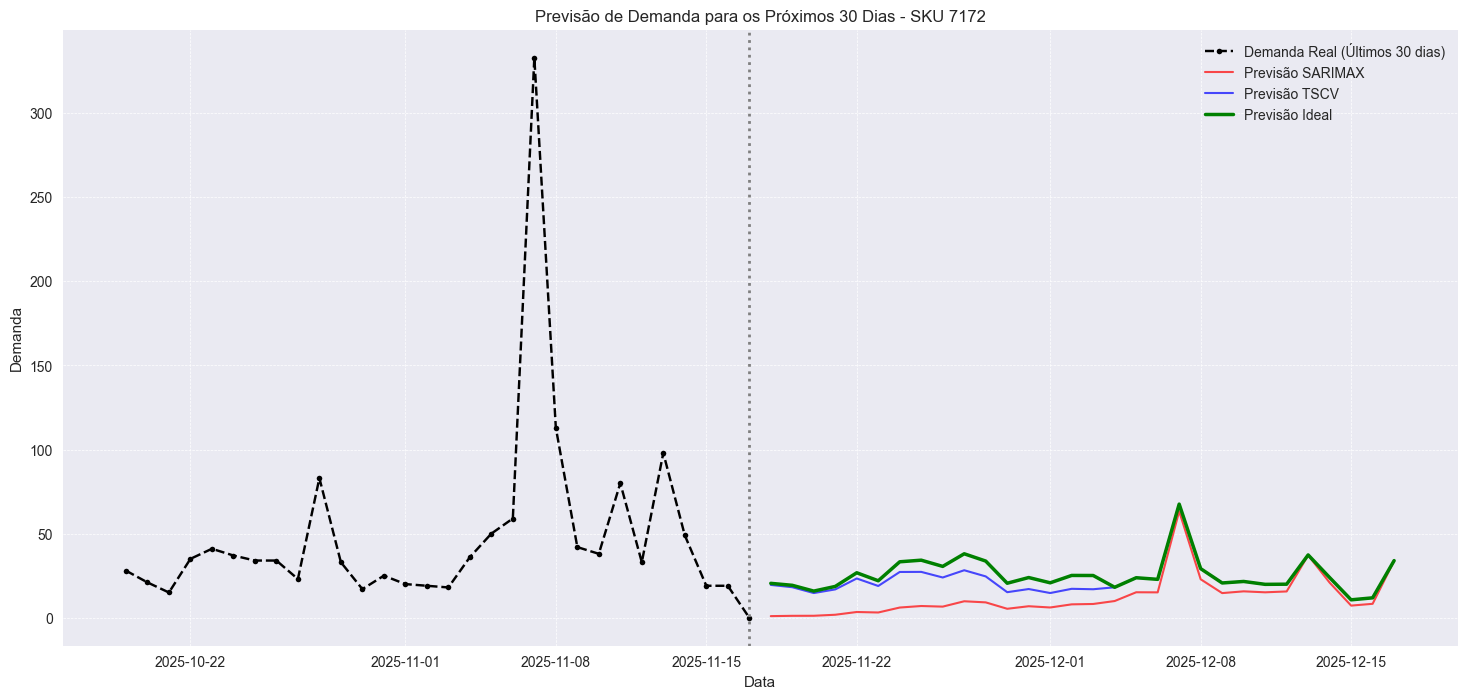


--- Gerando previsão de 30 dias para o SKU: 10036 ---
SKU 10036: Histórico de dados ajustado para começar em 2023-01-01, o primeiro dia com vendas.
--- INICIANDO PREVISÃO PARA OS PRÓXIMOS 30 DIAS (SKU: 10036) ---
Último preço registrado: 36.64 em 2025-11-17
Para os próximos 30 dias, o preço será baseado no mesmo dia 30 dias atrás, ou no último preço se a data não existir.
  Gerando gráfico de previsão futura...
SKU 10036: Histórico de dados ajustado para começar em 2023-01-01, o primeiro dia com vendas.
--- INICIANDO PREVISÃO PARA OS PRÓXIMOS 30 DIAS (SKU: 10036) ---
Último preço registrado: 36.64 em 2025-11-17
Para os próximos 30 dias, o preço será baseado no mesmo dia 30 dias atrás, ou no último preço se a data não existir.
  Gerando gráfico de previsão futura...

Gráfico de previsão salvo em: ../Graficos/previsao_30_dias_sku_10036.png

Gráfico de previsão salvo em: ../Graficos/previsao_30_dias_sku_10036.png


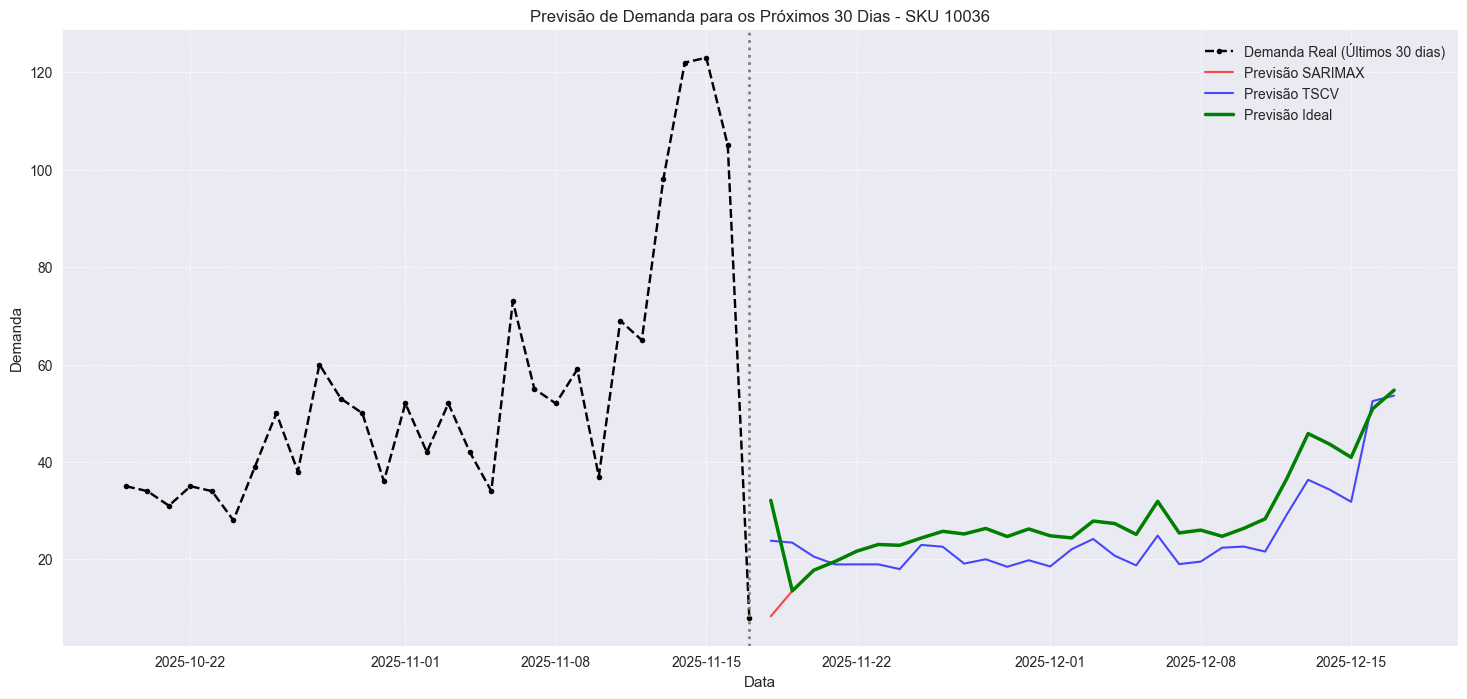


--- Gerando previsão de 30 dias para o SKU: 21120 ---
SKU 21120: Histórico de dados ajustado para começar em 2023-01-02, o primeiro dia com vendas.
--- INICIANDO PREVISÃO PARA OS PRÓXIMOS 30 DIAS (SKU: 21120) ---
Último preço registrado: 49.16 em 2025-11-17
Para os próximos 30 dias, o preço será baseado no mesmo dia 30 dias atrás, ou no último preço se a data não existir.
  Gerando gráfico de previsão futura...
SKU 21120: Histórico de dados ajustado para começar em 2023-01-02, o primeiro dia com vendas.
--- INICIANDO PREVISÃO PARA OS PRÓXIMOS 30 DIAS (SKU: 21120) ---
Último preço registrado: 49.16 em 2025-11-17
Para os próximos 30 dias, o preço será baseado no mesmo dia 30 dias atrás, ou no último preço se a data não existir.
  Gerando gráfico de previsão futura...

Gráfico de previsão salvo em: ../Graficos/previsao_30_dias_sku_21120.png

Gráfico de previsão salvo em: ../Graficos/previsao_30_dias_sku_21120.png


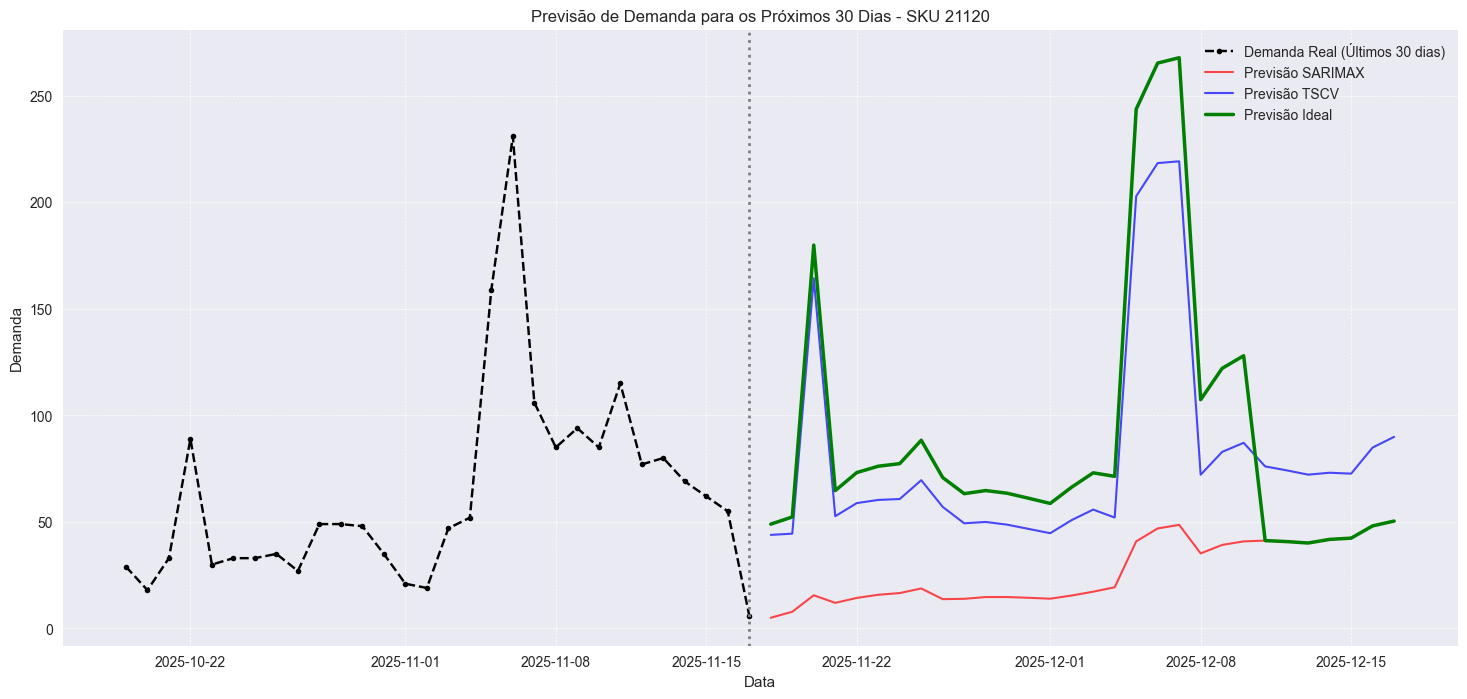


Arquivo de previsões futuras consolidado salvo em: c:\Users\joao.pcarvalho\Desktop\Git Repositórios\Forecast-vendas-e-elasticidade\Resultados\previsoes_futuras_consolidado.csv

Amostra das previsões de 30 dias consolidadas:


,Data,SKU,Preco,promocionado,Log_Preco,Quarta-feira,Terça-feira,previsao_TSCV,previsao_SARIMAX,previsao_total
0,2025-11-18,7172,338.45,0,5.824376,0,1,19.497292,0.947592,20.444884
1,2025-11-19,7172,344.01,0,5.840671,1,0,18.145838,1.130916,19.276754
2,2025-11-20,7172,351.45,0,5.862067,0,0,14.675807,1.158606,15.834413
3,2025-11-21,7172,341.43,0,5.833143,0,0,16.839130,1.770198,18.609328
4,2025-11-22,7172,318.79,0,5.764533,0,0,23.333024,3.401433,26.734458


In [4]:
import os
import sys
import pandas as pd
from IPython.display import display
import joblib
from statsmodels.tsa.statespace.sarimax import SARIMAXResults

current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from Functions.FNC_Previsoes import prever_demanda_com_modelos_salvos, pred_prox_30_dias
from Functions.FNC_Pro import Base_venda

# --- Definir os caminhos ---
caminho_pasta_modelos = os.path.join(project_root, 'Modelos')
caminho_planilha_precos = os.path.join(project_root, 'Forecast', 'Precos_para_previsoes.xlsx')
caminho_resultados = os.path.join(project_root, 'Resultados')


# --- 1. Previsões com base no arquivo de preços ---
print("--- INICIANDO PREVISÕES COM BASE NO ARQUIVO DE PREÇOS ---")
df_previsoes_salvas = prever_demanda_com_modelos_salvos(
    caminho_pasta_modelos,
    caminho_planilha_precos
)

if not df_previsoes_salvas.empty:
    # Salvar o arquivo consolidado
    caminho_arquivo_consolidado = os.path.join(caminho_resultados, 'previsoes_consolidado.csv')
    df_previsoes_salvas.to_csv(caminho_arquivo_consolidado, index=False, sep=';', decimal=',')
    print(f"\nArquivo de previsões consolidado salvo em: {caminho_arquivo_consolidado}")
    
    print("\nAmostra das previsões geradas a partir do arquivo de preços:")
    display(df_previsoes_salvas.head())


# --- 2. Previsões de 30 dias para o futuro (com gráficos) ---
print("\n\n--- INICIANDO PREVISÕES DE 30 DIAS PARA O FUTURO ---")
try:
    df_precos = pd.read_excel(caminho_planilha_precos)
    skus_para_prever = df_precos['SKU'].astype(str).unique()
    print(f"SKUs encontrados no arquivo de preços para gerar previsões futuras: {list(skus_para_prever)}")
except FileNotFoundError:
    print(f"ERRO: Arquivo de preços não encontrado em '{caminho_planilha_precos}'")
    skus_para_prever = []

previsoes_futuras_consolidadas = []
if skus_para_prever.any():
    for sku in skus_para_prever:
        print(f"\n--- Gerando previsão de 30 dias para o SKU: {sku} ---")
        
        caminho_modelo_tscv = os.path.join(caminho_pasta_modelos, f'modelo_tscv_{sku}.joblib')
        caminho_modelo_sarimax = os.path.join(caminho_pasta_modelos, f'modelo_sarimax_{sku}.pkl')

        if not os.path.exists(caminho_modelo_tscv) or not os.path.exists(caminho_modelo_sarimax):
            print(f"  AVISO: Modelos para o SKU {sku} não encontrados. Pulando.")
            continue
        
        modelo_tscv = joblib.load(caminho_modelo_tscv)
        modelo_sarimax = SARIMAXResults.load(caminho_modelo_sarimax)
        Venda = Base_venda(sku)
        
        if Venda.empty:
            print(f"  AVISO: Não foi possível carregar o histórico de vendas para o SKU {sku}. Pulando.")
            continue

        df_previsao_futura = pred_prox_30_dias(
            modelo_tscv,
            modelo_sarimax,
            Venda,
            sku,
            X_cols_tscv=['Log_Preco', 'Quarta-feira', 'Terça-feira', 'promocionado']
        )
        previsoes_futuras_consolidadas.append(df_previsao_futura)

if previsoes_futuras_consolidadas:
    df_previsoes_finais = pd.concat(previsoes_futuras_consolidadas, ignore_index=True)
    
    # Salvar o arquivo consolidado de previsões futuras
    caminho_futuro_consolidado = os.path.join(caminho_resultados, 'previsoes_futuras_consolidado.csv')
    df_previsoes_finais.to_csv(caminho_futuro_consolidado, index=False, sep=';', decimal=',')
    print(f"\nArquivo de previsões futuras consolidado salvo em: {caminho_futuro_consolidado}")

    print("\nAmostra das previsões de 30 dias consolidadas:")
    display(df_previsoes_finais.head())
else:
    print("\nNenhuma previsão de 30 dias foi gerada.")

### Subindo resultados consolidados no BQ

In [6]:
resultados_consolidados.to_csv('Resultados_Elasticidade.csv',index=False)


from google.cloud import storage


bucket_name = 'epoca-storage'

destination_blob_name1 = 'senior-estoque/Resultados Modelos/Forecast/Resultados_Elasticidade.csv'
storage_client = storage.Client()
bucket = storage_client.bucket(bucket_name)
blob = bucket.blob(destination_blob_name1)
blob.upload_from_filename('Resultados_Elasticidade.csv')

print("Arquivo 'Resultados_Elasticidade.csv' enviado com sucesso para o bucket do Google Cloud Storage.")

Arquivo 'Resultados_Elasticidade.csv' enviado com sucesso para o bucket do Google Cloud Storage.
